# Identifying Particles

Import necessary python libraries

In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
import deeptrack as dt
import keras
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# from random import randint 

import random
random.seed(14)

print("Import Complete")

Import Complete


## Loading in Images
Graph images, verify that the gold-standard center is accurate enough

[[48.5      50.5       0.55125 ]
 [48.5      54.5       0.55125 ]
 [48.5      52.5       0.55125 ]
 ...
 [51.5      52.5       0.077995]
 [51.5      50.5       0.077995]
 [51.5      51.5       0.077995]]
[48.5     50.5      0.55125]


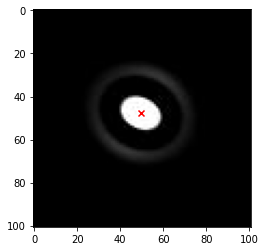

In [3]:
# Load in single image
img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# Convert to DeepTrack 2.0 Feature
img_data = dt.features.Dataset(img_data)
output_image = img_data.resolve()

# Display image
plt.imshow(output_image)

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset)

dataset = dataset / 2.0
print(dataset[:, 0:5])

label = dataset[0]
print(label)

# Plot single image against label position
plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

Finished loading all images
[48.5     50.5      0.55125]


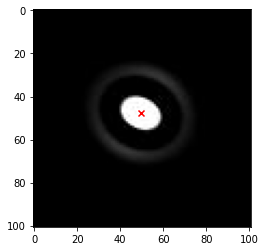

[48.5     50.5      0.55125]


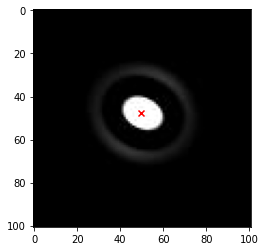

[50.5     50.5      0.63115]


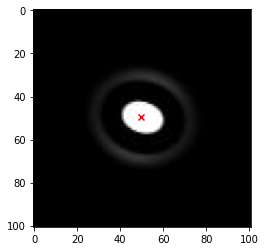

[49.5      52.5       0.077995]


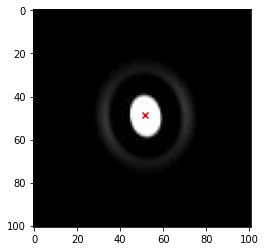

In [4]:
# ==========================================
# Load in all images
NUM_OF_IMAGES = 1000
all_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'image' + str(i + 1) + '.jpg'
#     print("Loading in an image named", image_name)
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
    all_images.append(img_data)

print("Finished loading all images")

img_data = all_images[0]
img_data = dt.features.Dataset(img_data)

output_image = img_data.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.show()

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0

# ==========================================
# Sample a few points to show the true label
chosen = [0, 6, 266, 977]
for i in chosen:
    # Select image plot
    img_data = all_images[i]
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()
    
    # Display image grayscale
    plt.imshow(np.squeeze(output_image), cmap='gray')
    
    # Load in label for selected data
    label = dataset[i]
    print(label)

    # Show image with true label
    plt.imshow(np.squeeze(output_image), cmap='gray')
    plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
    plt.show()
original_all_images = all_images.copy()



(1000, 101, 101)


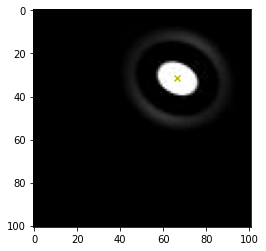

In [5]:
max_width = 101
# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0
new_all_images = [] # 57x57
# random range is 0-44

old_label = []
for i in range(1, 1001):
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')
    # print(img_data)
    C = img_data[22:-22, 22:-22]
# print(C)
    rand_x = random.randint(0, 44)
    rand_y = random.randint(0, 44)
    
    D = np.pad(C, ((rand_x, max_width - 57 - rand_x), (rand_y, max_width - 57 - rand_y)), 'constant')
#     print("Old coordinates were ", dataset[0], "Change by", rand_x, rand_y)
    old_label = dataset[0].copy()
    dataset[i - 1] = [dataset[i - 1][0] - 22 + rand_x, dataset[i - 1][1] - 22 + rand_y, dataset[i - 1][2]]
#     print("New coordinates are ", dataset[0])
    
    new_all_images.append(D)
#     plt.imshow(np.squeeze(D), cmap='gray')
#     plt.show()
    
new_all_images = np.array(new_all_images)
print(new_all_images.shape)
# print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1] - 1, label[0] - 1, c="y", marker="x") # 1-indexed, compensate with -1
# plt.scatter(old_label[1] - 1, old_label[0] - 1, c="g", marker="x") # 1-indexed, compensate with -1
plt.show()

In [6]:
# # The generator part
# for i in range(0, len(all_images)):
#     img_data = all_images[i] #all_images[0]
#     label = dataset[i]
#     img_data = dt.features.Dataset(img_data)
#     img_data.properties.setdefault('position', [label[1] - 1, label[0] - 1])
#     # print(img_data.properties)
#     all_images[0] = img_data
# all_images = np.array(all_images)

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [7]:
x_model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    conv_layers_dimensions=(1,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['accuracy'],
    output_activation="linear",
)

print("Model summary:")
x_model.summary()

Model summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 1)       10        
_________________________________________________________________
activation (Activation)      (None, 101, 101, 1)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2601)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                83264     
_________________________________________________________________
activation_1 (Activation)    (None, 32)       

In [8]:
# scaling = StandardScaler()
# scaling.fit(original_all_images)
# original_all_images = scaling.transform(original_all_images)

# original_all_images = np.array(original_all_images)
# all_images = tf.convert_to_tensor(original_all_images)



# Labels into individual sets.
x_dataset = np.zeros(1000)
y_dataset = np.zeros(1000)
angle_dataset = np.zeros(1000)

count = 0
for elem in dataset:
    x_dataset[count] = elem[0]
    y_dataset[count] = elem[1]
    count += 1

X_train, X_test, Y_train, Y_test = train_test_split(new_all_images, x_dataset, shuffle=False)

# Data
all_images = tf.convert_to_tensor(new_all_images)
train_images = tf.convert_to_tensor(X_train)


# x-coordinate position labels
x_dataset = tf.convert_to_tensor(x_dataset)
train_labels = tf.convert_to_tensor(Y_train)

In [9]:
print("Fitting the model")
history = x_model.fit(
    x=train_images,
    y=train_labels,
    epochs=500,
    validation_split=0.4
)

print("Model finished fitting")

Fitting the model
Epoch 1/500
15/15 [==============================] - 1s 34ms/step - loss: 46.7326 - accuracy: 0.0000e+00 - val_loss: 44.9557 - val_accuracy: 0.0000e+00
Epoch 2/500
15/15 [==============================] - 0s 26ms/step - loss: 43.4892 - accuracy: 0.0000e+00 - val_loss: 43.2438 - val_accuracy: 0.0000e+00
Epoch 3/500
15/15 [==============================] - 0s 26ms/step - loss: 42.1594 - accuracy: 0.0000e+00 - val_loss: 42.2550 - val_accuracy: 0.0000e+00
Epoch 4/500
15/15 [==============================] - 0s 27ms/step - loss: 41.2959 - accuracy: 0.0000e+00 - val_loss: 41.5090 - val_accuracy: 0.0000e+00
Epoch 5/500
15/15 [==============================] - 0s 26ms/step - loss: 40.5985 - accuracy: 0.0000e+00 - val_loss: 40.8591 - val_accuracy: 0.0000e+00
Epoch 6/500
15/15 [==============================] - 0s 33ms/step - loss: 39.9707 - accuracy: 0.0000e+00 - val_loss: 40.2540 - val_accuracy: 0.0000e+00
Epoch 7/500
15/15 [==============================] - 0s 26ms/step - lo

15/15 [==============================] - 0s 28ms/step - loss: 16.9644 - accuracy: 0.0000e+00 - val_loss: 17.1289 - val_accuracy: 0.0000e+00
Epoch 55/500
15/15 [==============================] - 0s 27ms/step - loss: 16.6871 - accuracy: 0.0000e+00 - val_loss: 16.8363 - val_accuracy: 0.0000e+00
Epoch 56/500
15/15 [==============================] - 0s 27ms/step - loss: 16.4411 - accuracy: 0.0000e+00 - val_loss: 16.5859 - val_accuracy: 0.0000e+00
Epoch 57/500
15/15 [==============================] - 0s 26ms/step - loss: 16.2219 - accuracy: 0.0000e+00 - val_loss: 16.3367 - val_accuracy: 0.0000e+00
Epoch 58/500
15/15 [==============================] - 0s 26ms/step - loss: 15.9904 - accuracy: 0.0000e+00 - val_loss: 16.0964 - val_accuracy: 0.0000e+00
Epoch 59/500
15/15 [==============================] - 0s 26ms/step - loss: 15.7828 - accuracy: 0.0000e+00 - val_loss: 15.8644 - val_accuracy: 0.0000e+00
Epoch 60/500
15/15 [==============================] - 0s 26ms/step - loss: 15.5796 - accuracy: 

15/15 [==============================] - 0s 32ms/step - loss: 11.7862 - accuracy: 0.0000e+00 - val_loss: 11.6827 - val_accuracy: 0.0000e+00
Epoch 108/500
15/15 [==============================] - 0s 27ms/step - loss: 11.7719 - accuracy: 0.0000e+00 - val_loss: 11.6718 - val_accuracy: 0.0000e+00
Epoch 109/500
15/15 [==============================] - 0s 31ms/step - loss: 11.7582 - accuracy: 0.0000e+00 - val_loss: 11.6553 - val_accuracy: 0.0000e+00
Epoch 110/500
15/15 [==============================] - 0s 28ms/step - loss: 11.7416 - accuracy: 0.0000e+00 - val_loss: 11.6390 - val_accuracy: 0.0000e+00
Epoch 111/500
15/15 [==============================] - 0s 34ms/step - loss: 11.7312 - accuracy: 0.0000e+00 - val_loss: 11.6308 - val_accuracy: 0.0000e+00
Epoch 112/500
15/15 [==============================] - 0s 32ms/step - loss: 11.7214 - accuracy: 0.0000e+00 - val_loss: 11.6217 - val_accuracy: 0.0000e+00
Epoch 113/500
15/15 [==============================] - 1s 36ms/step - loss: 11.7139 - accu

15/15 [==============================] - 0s 29ms/step - loss: 11.4806 - accuracy: 0.0000e+00 - val_loss: 11.4067 - val_accuracy: 0.0000e+00
Epoch 161/500
15/15 [==============================] - 0s 32ms/step - loss: 11.4806 - accuracy: 0.0000e+00 - val_loss: 11.4067 - val_accuracy: 0.0000e+00
Epoch 162/500
15/15 [==============================] - 0s 32ms/step - loss: 11.4810 - accuracy: 0.0000e+00 - val_loss: 11.4067 - val_accuracy: 0.0000e+00
Epoch 163/500
15/15 [==============================] - 1s 35ms/step - loss: 11.4812 - accuracy: 0.0000e+00 - val_loss: 11.4067 - val_accuracy: 0.0000e+00
Epoch 164/500
15/15 [==============================] - 0s 32ms/step - loss: 11.4840 - accuracy: 0.0000e+00 - val_loss: 11.4071 - val_accuracy: 0.0000e+00
Epoch 165/500
15/15 [==============================] - 1s 36ms/step - loss: 11.4813 - accuracy: 0.0000e+00 - val_loss: 11.4067 - val_accuracy: 0.0000e+00
Epoch 166/500
15/15 [==============================] - 1s 34ms/step - loss: 11.4811 - accu

15/15 [==============================] - 0s 26ms/step - loss: 3.0335 - accuracy: 0.0000e+00 - val_loss: 3.6828 - val_accuracy: 0.0000e+00
Epoch 214/500
15/15 [==============================] - 0s 27ms/step - loss: 2.8467 - accuracy: 0.0000e+00 - val_loss: 3.5968 - val_accuracy: 0.0000e+00
Epoch 215/500
15/15 [==============================] - 0s 33ms/step - loss: 2.7419 - accuracy: 0.0000e+00 - val_loss: 3.4911 - val_accuracy: 0.0000e+00
Epoch 216/500
15/15 [==============================] - 0s 27ms/step - loss: 2.7251 - accuracy: 0.0000e+00 - val_loss: 3.3231 - val_accuracy: 0.0000e+00
Epoch 217/500
15/15 [==============================] - 0s 33ms/step - loss: 2.5593 - accuracy: 0.0000e+00 - val_loss: 3.2711 - val_accuracy: 0.0000e+00
Epoch 218/500
15/15 [==============================] - 0s 26ms/step - loss: 2.4451 - accuracy: 0.0000e+00 - val_loss: 3.1314 - val_accuracy: 0.0000e+00
Epoch 219/500
15/15 [==============================] - 0s 27ms/step - loss: 2.3081 - accuracy: 0.0000e

Epoch 267/500
15/15 [==============================] - 0s 26ms/step - loss: 0.5165 - accuracy: 0.0000e+00 - val_loss: 1.5274 - val_accuracy: 0.0000e+00
Epoch 268/500
15/15 [==============================] - 0s 27ms/step - loss: 0.5015 - accuracy: 0.0000e+00 - val_loss: 1.5395 - val_accuracy: 0.0000e+00
Epoch 269/500
15/15 [==============================] - 0s 26ms/step - loss: 0.5035 - accuracy: 0.0000e+00 - val_loss: 1.5400 - val_accuracy: 0.0000e+00
Epoch 270/500
15/15 [==============================] - 0s 26ms/step - loss: 0.4861 - accuracy: 0.0000e+00 - val_loss: 1.5482 - val_accuracy: 0.0000e+00
Epoch 271/500
15/15 [==============================] - 0s 25ms/step - loss: 0.4689 - accuracy: 0.0000e+00 - val_loss: 1.5172 - val_accuracy: 0.0000e+00
Epoch 272/500
15/15 [==============================] - 0s 25ms/step - loss: 0.4612 - accuracy: 0.0000e+00 - val_loss: 1.4986 - val_accuracy: 0.0000e+00
Epoch 273/500
15/15 [==============================] - 0s 26ms/step - loss: 0.4340 - acc

Epoch 321/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2487 - accuracy: 0.0000e+00 - val_loss: 1.3177 - val_accuracy: 0.0000e+00
Epoch 322/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2432 - accuracy: 0.0000e+00 - val_loss: 1.2878 - val_accuracy: 0.0000e+00
Epoch 323/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2497 - accuracy: 0.0000e+00 - val_loss: 1.3025 - val_accuracy: 0.0000e+00
Epoch 324/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2367 - accuracy: 0.0000e+00 - val_loss: 1.2975 - val_accuracy: 0.0000e+00
Epoch 325/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2143 - accuracy: 0.0000e+00 - val_loss: 1.3150 - val_accuracy: 0.0000e+00
Epoch 326/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2355 - accuracy: 0.0000e+00 - val_loss: 1.3021 - val_accuracy: 0.0000e+00
Epoch 327/500
15/15 [==============================] - 0s 26ms/step - loss: 0.2107 - acc

Epoch 375/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1598 - accuracy: 0.0000e+00 - val_loss: 1.2667 - val_accuracy: 0.0000e+00
Epoch 376/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1577 - accuracy: 0.0000e+00 - val_loss: 1.2535 - val_accuracy: 0.0000e+00
Epoch 377/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1524 - accuracy: 0.0000e+00 - val_loss: 1.2756 - val_accuracy: 0.0000e+00
Epoch 378/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1544 - accuracy: 0.0000e+00 - val_loss: 1.2585 - val_accuracy: 0.0000e+00
Epoch 379/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1711 - accuracy: 0.0000e+00 - val_loss: 1.2514 - val_accuracy: 0.0000e+00
Epoch 380/500
15/15 [==============================] - 0s 25ms/step - loss: 0.1722 - accuracy: 0.0000e+00 - val_loss: 1.2660 - val_accuracy: 0.0000e+00
Epoch 381/500
15/15 [==============================] - 0s 28ms/step - loss: 0.1868 - acc

Epoch 429/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1345 - accuracy: 0.0000e+00 - val_loss: 1.2371 - val_accuracy: 0.0000e+00
Epoch 430/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1323 - accuracy: 0.0000e+00 - val_loss: 1.2495 - val_accuracy: 0.0000e+00
Epoch 431/500
15/15 [==============================] - 0s 27ms/step - loss: 0.1494 - accuracy: 0.0000e+00 - val_loss: 1.2517 - val_accuracy: 0.0000e+00
Epoch 432/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1526 - accuracy: 0.0000e+00 - val_loss: 1.2475 - val_accuracy: 0.0000e+00
Epoch 433/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1464 - accuracy: 0.0000e+00 - val_loss: 1.2284 - val_accuracy: 0.0000e+00
Epoch 434/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1323 - accuracy: 0.0000e+00 - val_loss: 1.2266 - val_accuracy: 0.0000e+00
Epoch 435/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1249 - acc

Epoch 483/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1101 - accuracy: 0.0000e+00 - val_loss: 1.2798 - val_accuracy: 0.0000e+00
Epoch 484/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1113 - accuracy: 0.0000e+00 - val_loss: 1.2738 - val_accuracy: 0.0000e+00
Epoch 485/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1073 - accuracy: 0.0000e+00 - val_loss: 1.2844 - val_accuracy: 0.0000e+00
Epoch 486/500
15/15 [==============================] - 0s 31ms/step - loss: 0.1105 - accuracy: 0.0000e+00 - val_loss: 1.2746 - val_accuracy: 0.0000e+00
Epoch 487/500
15/15 [==============================] - 0s 28ms/step - loss: 0.1207 - accuracy: 0.0000e+00 - val_loss: 1.2662 - val_accuracy: 0.0000e+00
Epoch 488/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1344 - accuracy: 0.0000e+00 - val_loss: 1.2959 - val_accuracy: 0.0000e+00
Epoch 489/500
15/15 [==============================] - 0s 26ms/step - loss: 0.1284 - acc

In [10]:
x_predicted = np.array(x_model.predict_on_batch(all_images))
# print(x_predicted)
# print(x_dataset)

count = 0
for i in range(0, 1000):
    difference = round(round(x_predicted[i][0], 1) - float(x_dataset[i]), 2)
    if abs(difference) <= 1.0:
        count += 1
#     else:
#         print(difference, "(", round(x_predicted[i][0], 1), ",", float(x_dataset[i]), ")")


print("Training Accuracy: ", count / len(x_dataset) * 100, "%")

# 357 correct within 0.5
# 613 correct within 1.0

# ========
test_images = tf.convert_to_tensor(X_test)
test_labels = tf.convert_to_tensor(Y_test)

x_predicted = np.array(x_model.predict_on_batch(test_images))
# print(x_predicted)
# print(x_dataset)

count = 0
for i in range(0, len(test_labels)):
    difference = round(round(x_predicted[i][0], 1) - float(test_labels[i]), 2)
    if abs(difference) <= 1.0:
        count += 1
#     else:
#         print(difference, "(", round(x_predicted[i][0], 1), ",", float(x_dataset[i]), ")")


print("Test Accuracy", count / len(test_labels) * 100, "%")


Training Accuracy:  73.3 %
Test Accuracy 52.0 %


In [11]:
print(set(np.array(x_dataset)))

{26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5}


Final loss: 0.113
Final accuracy: 0.0
Final val_loss: 1.263
Final val_accuracy: 0.0


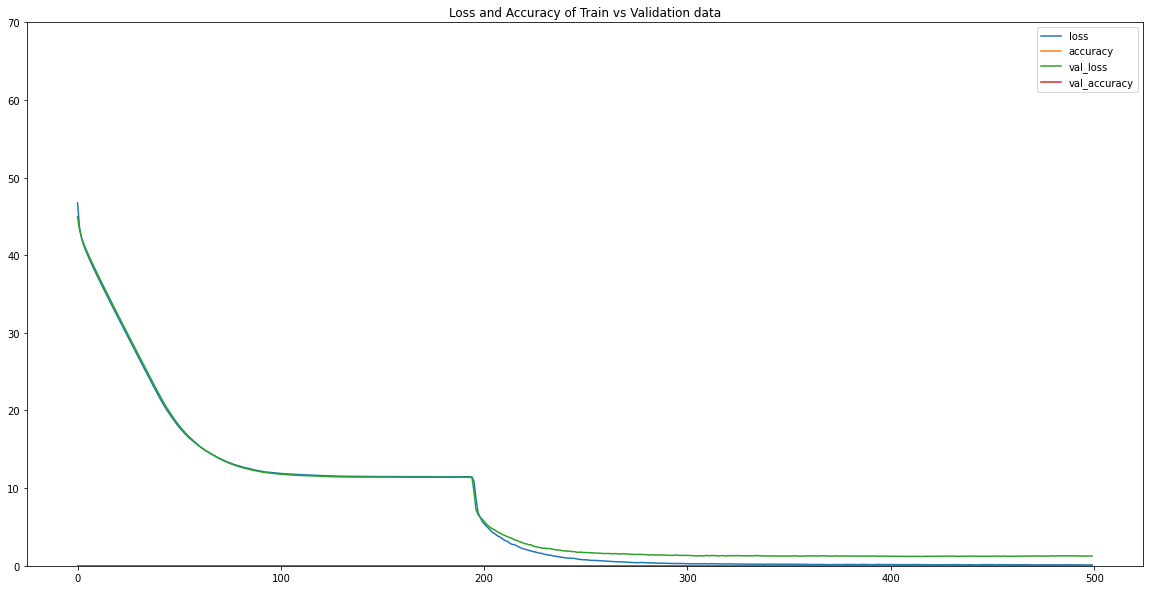

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [12]:
def plot_history(history, ylim=70): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep
plot_history(history)

In [13]:
# y_model = dt.models.convolutional(
#     input_shape=(101, 101, 1), 
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_absolute_error', 'accuracy']
# )

# print("Model summary:")
# y_model.summary()

# print("Fitting the model")
# history = y_model.fit(
#     x=all_images,
#     y=y_dataset,
#     epochs=30,
#     validation_split=0.4
# )

# print("Model finished fitting")

In [14]:
# y_predicted = y_model.predict_on_batch(all_images)
# print(y_predicted)
# print(y_dataset)